<a href="https://colab.research.google.com/github/sankethgadadinni/Tomatoleafdiseaseclassification/blob/main/tomatodiseaseclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sankethgadadinni","key":"f6711e33d3a8e8d7a3b2198fa9f4f8bd"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:

!kaggle datasets download -d kaustubhb999/tomatoleaf


 92% 165M/179M [00:01<00:00, 98.5MB/s]
100% 179M/179M [00:01<00:00, 97.6MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatoleaf.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [32]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets,transforms,models
import torch.optim as optim
from torch.autograd import Variable
import time 
from torch.optim import lr_scheduler
import copy
import numpy as np



In [7]:
train_on_gpu = torch.cuda.is_available()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda')

In [11]:
base_dir = '/content/tomato'
train_path = os.path.join(base_dir,'train')
val_path = os.path.join(base_dir,'val')

In [37]:
data_transform = {
    'train' : transforms.Compose([
              transforms.RandomRotation(30),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]),
     'val' :  transforms.Compose([
              transforms.Resize(224),
              transforms.ToTensor(),
              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])        
}

In [38]:
image_datasets = {x:datasets.ImageFolder(os.path.join(base_dir,x), transform=data_transform[x]) for x in ['train','val']}


In [39]:
data_loaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train','val']}

In [40]:
for batch_idx, data in enumerate(data_loaders['train']):
    images, labels = data 
    print(labels)
    break


tensor([4, 0, 2, 8, 9, 8, 1, 2, 8, 2, 2, 7, 6, 4, 5, 8, 2, 5, 3, 0, 4, 5, 1, 3,
        7, 1, 4, 4, 5, 7, 5, 0])


In [43]:
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}

In [44]:
classes = image_datasets['train'].classes

In [45]:
num_claases = len(classes)

In [46]:
num_claases

10

In [47]:
import matplotlib.pyplot as plt
import numpy as np

norm_mean = [0.5,0.5,0.5]
norm_std = [0.5,0.5,0.5]

def imshow_numpy(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.grid(False)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(norm_mean)
    std = np.array(norm_std)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

torch.Size([32, 3, 256, 256])


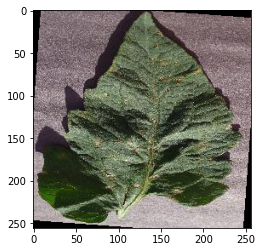

In [48]:

images, labels = next(iter(data_loaders['train']))
imshow_numpy(images[0].numpy())
print(images.shape)

In [49]:
model = models.resnet34(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
for param in model.parameters():
    param.requires_grad = False

In [51]:
model.fc = nn.Sequential(nn.Linear(512,num_claases),
                                 nn.LogSoftmax(dim=1))

In [52]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1,num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [60]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model.to(device); 

In [61]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3687 Acc: 0.8788
val Loss: 0.6065 Acc: 0.7820

Epoch 2/10
----------
train Loss: 0.3462 Acc: 0.8845
val Loss: 0.6277 Acc: 0.7720

Epoch 3/10
----------
train Loss: 0.3373 Acc: 0.8902
val Loss: 0.5676 Acc: 0.7980

Epoch 4/10
----------
train Loss: 0.3393 Acc: 0.8846
val Loss: 0.6388 Acc: 0.7930

Epoch 5/10
----------
train Loss: 0.3159 Acc: 0.8953
val Loss: 0.5844 Acc: 0.7940

Epoch 6/10
----------
train Loss: 0.3086 Acc: 0.8984
val Loss: 0.5762 Acc: 0.7940

Epoch 7/10
----------
train Loss: 0.3036 Acc: 0.9013
val Loss: 0.5867 Acc: 0.7930

Epoch 8/10
----------
train Loss: 0.3059 Acc: 0.8998
val Loss: 0.5741 Acc: 0.7970

Epoch 9/10
----------
train Loss: 0.3049 Acc: 0.9013
val Loss: 0.5688 Acc: 0.8050

Epoch 10/10
----------
train Loss: 0.2980 Acc: 0.9053
val Loss: 0.5704 Acc: 0.8000

Training complete in 9m 18s
Best val Acc: 0.805000
